# Split synthetic neighborhoods (Exp4-8) into three generalization sets

Splits are done based on parent (WT) sequences of each sequence neighborhood. Neighborhoods are split randomly across the three sets. 

Re-run top to bottom April 30, 2019.

In [1]:
import sys
import os
import random

import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

sys.path.append('../common')
import data_io_utils
import paths
import utils
import constants

%reload_ext autoreload
%autoreload 2

## Set seed for reproducibility

In [2]:
np.random.seed(1)
random.seed(1)

## Define how to split up variants

In [3]:
SPLIT_BY = 'nearest_parent'

## Sync data

In [4]:
paths.SYNTHETIC_NEIGH_DATA_FILE

'/notebooks/analysis/common/../../data/s3/datasets/Exp4-8_inferred_brightness_parents_assigned.csv'

In [5]:
data_io_utils.sync_s3_path_to_local(paths.SYNTHETIC_NEIGH_DATA_FILE, is_single_file=True)

# MD5 from A049_common in mlpe-gfp-pilot repo
data_io_utils.verify_file_md5_checksum(paths.SYNTHETIC_NEIGH_DATA_FILE, 'c026ee2ad31dd8d4d468b3b18ec70dd7')

syn_neigh_df = pd.read_csv(paths.SYNTHETIC_NEIGH_DATA_FILE)

print(syn_neigh_df.shape)
syn_neigh_df.head()

(104285, 4)


,seq,quantitative_function,nearest_parent,nearest_parent_min_dist
0,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLCF...,1.448735e-01,mc_training_day_seed_033_i_273,mc_training_day_seed_033_i_273
1,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLCF...,2.007325e-07,mc_training_day_seed_041_i_097,Unassigned
2,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLCF...,1.448735e-01,mc_training_day_seed_041_i_097,mc_training_day_seed_041_i_097
3,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLCF...,1.448735e-01,mc_training_day_seed_036_i_072,Unassigned
4,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLEC...,7.176033e-01,mc_training_day_seed_021_i_046,mc_training_day_seed_021_i_046


Load parent sequences.

In [6]:
data_io_utils.sync_s3_path_to_local(paths.SYNTHETIC_NEIGH_PARENTS_INFO_FILE, is_single_file=True)
syn_parents_df = pd.read_csv(paths.SYNTHETIC_NEIGH_PARENTS_INFO_FILE)

# SHUFFLE. This randomizes split later in the notebook.
syn_parents_df = syn_parents_df.sample(frac=1).reset_index(drop=True)

print(syn_parents_df.shape)
syn_parents_df.head()

(286, 2)


,id,seq
0,mc_training_day_seed_036_i_072,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLKF...
1,Exp8_11,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLKF...
2,mc_training_day_seed_010_i_048,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLKF...
3,Exp7_72,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLKF...
4,mc_training_day_seed_030_i_296,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLKF...


## Visualize parent relationships using MDS.

In [7]:
parent_seqs = list(syn_parents_df['seq'])
parent_ids = list(syn_parents_df['id'])

parent_seqs = [constants.AVGFP_AA_SEQ, constants.SFGFP_AA_SEQ] + parent_seqs
parent_ids = ['avGFP', 'sfGFP'] + parent_ids

D = utils.levenshtein_distance_matrix(parent_seqs)
s = MDS(n_components=2, dissimilarity='precomputed').fit_transform(D)

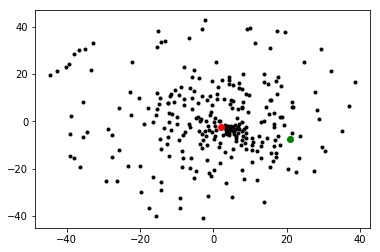

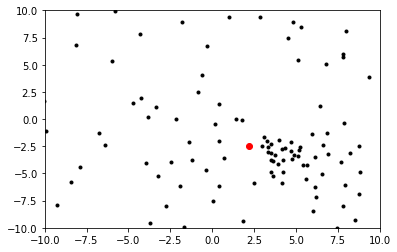

In [8]:
plt.plot(s[:,0], s[:,1], '.k')
plt.plot(s[0,0], s[0,1], 'og')
plt.plot(s[1,0], s[1,1], 'or')
plt.show()

# Zoom in 
plt.plot(s[:,0], s[:,1], '.k')
plt.plot(s[0,0], s[0,1], 'og')
plt.plot(s[1,0], s[1,1], 'or')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.show()

As these sequences are mostly sfGFP derived, it makes sense sfGFP sits at the center, with avGFP in the mid-periphery. 

## Visualize brightness distribution of the parents.

In [9]:
mask = syn_neigh_df['seq'].apply(lambda x: x in parent_seqs)

syn_neigh_parents_df = syn_neigh_df[mask]

print(syn_neigh_parents_df.shape)
syn_neigh_parents_df.head()

(228, 4)


,seq,quantitative_function,nearest_parent,nearest_parent_min_dist
519,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLKC...,0.485817,mc_training_day_seed_016_i_133,mc_training_day_seed_016_i_133
943,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLKC...,1.139180,mc_training_day_seed_020_i_051,mc_training_day_seed_020_i_051
1108,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLKC...,1.026093,mc_training_day_seed_016_i_012,mc_training_day_seed_016_i_012
1583,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLKC...,0.043597,mc_training_day_seed_020_i_219,mc_training_day_seed_020_i_219
2292,MRKGEELFTGFVTILVELDGDVNGHKFSVRGEGEGDATNGKLTLKF...,1.668192,mc_training_day_seed_003_i_011,mc_training_day_seed_003_i_011


Couldn't find all of the parents, but got most of them. 

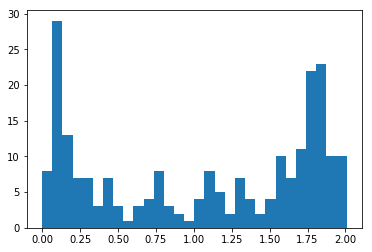

In [10]:
plt.hist(syn_neigh_parents_df['quantitative_function'], bins=30)
plt.show()

In [11]:
print(np.sum(syn_neigh_parents_df['quantitative_function'] > 1)) # Num parents brighter than avGFP

129


There are a lot of parents brighter than avGFP, so I feel comfortable splitting randomly into thirds.

## Split the dataset by parent.

In [12]:
kf = KFold(n_splits=3)
split_indices = []
for _, sp_idx in kf.split(parent_seqs):
    split_indices.append(sp_idx)

Note split indicies are continuous, but we shuffled the parents metadata dataframe above.

In [13]:
split_indices[1]

array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191])

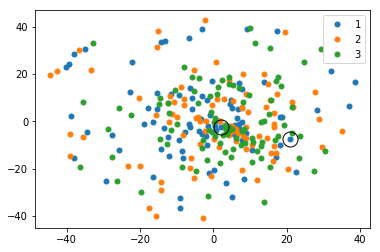

In [14]:
for si in split_indices:
    plt.plot(s[si,0], s[si,1], '.', markersize=10)
    
plt.plot(s[0,0], s[0,1], 'o', markerfacecolor='None',  markeredgecolor='k', markersize=15)
plt.plot(s[1,0], s[1,1], 'o', markerfacecolor='None',  markeredgecolor='k', markersize=15)
plt.legend([1,2,3])
plt.show()

Note while avGFP and sfGFP are marked, their IDs will not be found in the full dataset dataframe and hence wont appear in the TTS.

Perform the splits. We will split by parent, using the nearest parent to decide where a variant goes.

In [15]:
parent_ids = np.array(parent_ids)

split_dfs = []
for sidx in split_indices:
    print(sidx)
    parent_ids_split = list(parent_ids[sidx])
    
    mask = syn_neigh_df[SPLIT_BY].apply(lambda x: x in parent_ids_split)
    split_dfs.append(syn_neigh_df[mask])    

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
[ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
[192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269

Some final checks

In [16]:
# Assert all examples are used
assert np.sum([sdf.shape[0] for sdf in split_dfs]) == syn_neigh_df.shape[0]

# Assert no overlaps in which neighborhoods are being used between sets
for i in range(len(split_dfs)):
    for j in range(i+1, len(split_dfs)):
        s1 = split_dfs[i]
        s2 = split_dfs[j]
        print(set(s1[SPLIT_BY]).intersection(set(s2[SPLIT_BY])))
        
        assert len(set(s1[SPLIT_BY]).intersection(set(s2[SPLIT_BY]))) == 0

set()
set()
set()


## Export

Generate MD5 checksums to validate reproducibility of these files. Once this notebook is committed, we can always refer back to these checksums. 

In [17]:
output_file_prefix = 'Exp4-8_inferred_brightness_parents_assigned_split_'

os.makedirs(os.path.join(paths.TTS_SPLITS_DIR, 'generalization_sets'), exist_ok=True)

for i,sdf in enumerate(split_dfs):
    ofile = os.path.join(paths.TTS_SPLITS_DIR, 'generalization_sets', output_file_prefix + str(i) + '.csv')
    sdf.to_csv(ofile, index=False)
    
    print(sdf.shape)
    print(ofile)
    print(data_io_utils.generate_md5_checksum(ofile))
    print()

(37606, 4)
/notebooks/analysis/common/../../data/s3/datasets/tts_splits/generalization_sets/Exp4-8_inferred_brightness_parents_assigned_split_0.csv
9ec5ec061b67ae3c7a1a9e845843823d

(33726, 4)
/notebooks/analysis/common/../../data/s3/datasets/tts_splits/generalization_sets/Exp4-8_inferred_brightness_parents_assigned_split_1.csv
a4d72ec1bc1bd3ac4c2c191666914897

(32953, 4)
/notebooks/analysis/common/../../data/s3/datasets/tts_splits/generalization_sets/Exp4-8_inferred_brightness_parents_assigned_split_2.csv
9619cb6223870b30876ec93ce04fdac3



Manually verified these results are reproducible by running the notebook 2x top to bottom and checking MD5 checksums.

## Sync back up to S3

In [18]:
# Post publication note: Disabling sync to read-only bucket.
#data_io_utils.sync_local_path_to_s3(paths.TTS_SPLITS_DIR)